<a href="https://colab.research.google.com/github/Pulsar-kkaturi/DL-Education/blob/master/VisionDL_Lecture/Lecture7_Segmentation_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation

In [ ]:
import numpy as np
import os, matplotlib, random
from matplotlib import pyplot as plt

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import backend as K

In [ ]:
# 영상처리 관련 라이브러리 불러오기
import skimage
from skimage import io as skio
from skimage import transform as skit
from skimage import morphology as skim

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. U-Net

### 1.1. Data Loading

* Dataset Download
  - reference link: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation

In [ ]:
# 데이터셋을 이 세션으로 불러오기
!git clone https://github.com/Pulsar-kkaturi/DL-Education.git

Cloning into 'DL-Education'...
remote: Enumerating objects: 903, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 903 (delta 174), reused 194 (delta 142), pack-reused 663
Receiving objects: 100% (903/903), 245.72 MiB | 38.56 MiB/s, done.
Resolving deltas: 100% (492/492), done.


In [ ]:
# 압축 풀기
!tar -zxf ./DL-Education/dataset/brain_seg_2d.tar.gz

* 데이터 경로 지정

In [ ]:
img_fol_path = './brain_seg_2d/images'
msk_fol_path = './brain_seg_2d/masks'
img_file_list = [f for f in sorted(os.listdir(img_fol_path))]
msk_file_list = [f for f in sorted(os.listdir(msk_fol_path))]
# print(img_file_list)
# print(msk_file_list)

img_list, msk_list = [], []
for i, i_ in enumerate(img_file_list):
  img_path = os.path.join(img_fol_path, i_)
  msk_path = os.path.join(msk_fol_path, msk_file_list[i])
  img_arr = skio.imread(img_path)
  msk_arr = skio.imread(msk_path)
  img_list.append(img_arr)
  msk_list.append(msk_arr)

print('Image numbers = ', len(img_list))
print('Mask numbers = ', len(msk_list))

Image numbers =  1000
Mask numbers =  1000


* 이미지 & 레이블 확인

In [ ]:
# 이미지 정보
print('이미지 크기 = ', img_list[0].shape)
print(f'이미지 최대값/최소값 = {np.max(img_list[0])}/{np.min(img_list[0])}')
# 마스크 정보
print('마스크 크기 = ', msk_list[0].shape)
print(f'마스크 최대값/최소값 = {np.max(msk_list[0])}/{np.min(msk_list[0])}')

이미지 크기 =  (512, 512)
이미지 최대값/최소값 = 255/0
마스크 크기 =  (512, 512)
마스크 최대값/최소값 = 255/0


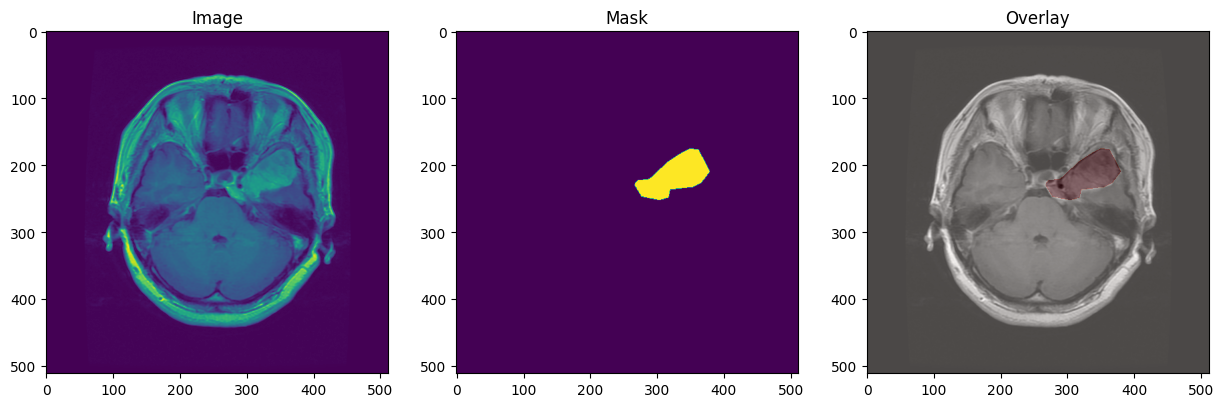

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.title('Image')
plt.imshow(img_list[0])
plt.subplot(132)
plt.title('Mask')
plt.imshow(msk_list[0])
plt.subplot(133)
plt.title('Overlay')
plt.imshow(img_list[0], cmap='gray')
plt.imshow(msk_list[0], cmap='Reds', alpha=0.3)

### 1.2. Data Pre-processing

In [ ]:
img_size = (256, 256) # 이미지 사이즈 정규화
num_classes = 1 # 레이블 종류 (tumor 1개)

# 이미지 전처리
resized_imgs = [skit.resize(img, img_size, anti_aliasing=True) for img in img_list] # 이미지 크기 리사이징
img_arrays = np.expand_dims(np.array(resized_imgs, dtype=np.float32), axis=-1) # 이미지를 array로 변환
input_imgs = (img_arrays - np.min(img_arrays))/(np.max(img_arrays)-np.min(img_arrays)) # 이미지 정규화 (0~1)

# 마스크 전처리
resized_msks = [skit.resize(msk, img_size) for msk in msk_list] # 이미지 크기 리사이징
msk_arrays = np.expand_dims(np.array(resized_msks), axis=-1) # 마스크를 array로 변환
targets = np.where(msk_arrays > 0, 1, 0) # 레이블 형태(0,1)로 변환
targets = targets.astype(np.uint8)

# 이미지 정보
print('입력 어레이 크기 = ', input_imgs.shape)
print(f'입력 어레이 최대값/최소값 = {np.max(input_imgs)}/{np.min(input_imgs)}')
# 마스크 정보
print('타겟 어레이 크기 = ', targets.shape)
print(f'타켓 어레이 최대값/최소값 = {np.max(targets)}/{np.min(targets)}')

입력 어레이 크기 =  (1000, 256, 256, 1)
입력 어레이 최대값/최소값 = 1.0/0.0
타겟 어레이 크기 =  (1000, 256, 256, 1)
타켓 어레이 최대값/최소값 = 1/0


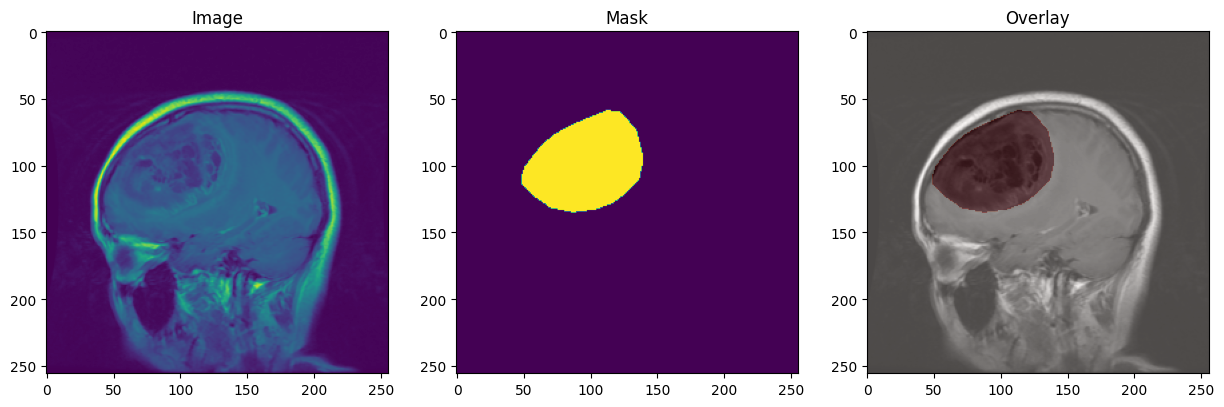

In [ ]:
# 검증 데이터셋 분할
num_val_samples = 100 # 검증 데이터셋에는 100건 사용
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

# 검증 데이터셋 확인
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.title('Image')
plt.imshow(val_input_imgs[0])
plt.subplot(132)
plt.title('Mask')
plt.imshow(val_targets[0])
plt.subplot(133)
plt.title('Overlay')
plt.imshow(val_input_imgs[0], cmap='gray')
plt.imshow(val_targets[0], cmap='Reds', alpha=0.3)

### 1.3. Model Build

In [ ]:
class UNet:
    def __init__(self, params):
        self.input_size = params['input_size']
        self.conv_act = params['conv_act']
        self.output_num = params['output_num']
        self.output_act = params['output_act']
    def __call__(self, model_name):
        if model_name == "UNet":
            inputs = Input(shape=self.input_size, name='input_layer')
            # Encoder
            cblock1 = self.conv_block(inputs, 1, 2, 32, 3, self.conv_act)
            pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(1))(cblock1)
            cblock2 = self.conv_block(pool1, 2, 2, 64, 3, self.conv_act)
            pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(2))(cblock2)
            cblock3 = self.conv_block(pool2, 3, 2, 128, 3, self.conv_act)
            pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(3))(cblock3)
            cblock4 = self.conv_block(pool3, 4, 2, 256, 3, self.conv_act)
            pool4 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(4))(cblock4)
            cblock5 = self.conv_block(pool4, 5, 2, 512, 3, self.conv_act)
            pool5 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(5))(cblock5)
            # Bottleneck
            bottleneck = self.conv_block(pool5, 4, 2, 1024, 3, self.conv_act, bottle=True)
            # Decoder
            up1 = layers.Conv2DTranspose(512, 2, strides=2, name='conv_trans%s' %(1))(bottleneck)
            ublock1 = self.up_block(up1, cblock5, 1, 2, 512, 3, self.conv_act)
            up2 = layers.Conv2DTranspose(256, 2, strides=2, name='conv_trans%s' %(2))(ublock1)
            ublock2 = self.up_block(up2, cblock4, 2, 2, 256, 3, self.conv_act)
            up3 = layers.Conv2DTranspose(128, 2, strides=2, name='conv_trans%s' %(3))(ublock2)
            ublock3 = self.up_block(up3, cblock3, 3, 2, 128, 3, self.conv_act)
            up4 = layers.Conv2DTranspose(64, 2, strides=2, name='conv_trans%s' %(4))(ublock3)
            ublock4 = self.up_block(up4, cblock2, 4, 2, 64, 3, self.conv_act)
            up5 = layers.Conv2DTranspose(32, 2, strides=2, name='conv_trans%s' %(5))(ublock4)
            ublock5 = self.up_block(up5, cblock1, 5, 2, 32, 3, self.conv_act)
            outputs = layers.Conv2D(self.output_num, 1, padding='same', activation=self.output_act, name='output_layer')(ublock5)
            model = Model(inputs=inputs, outputs=outputs)
            return model
    def conv_block(self,
                   lr_conv, # input layer
                   bk_num:int, # block number
                   lr_num:int, # convolution number
                   filters:int, # filter number
                   kern_size:int, # kernel size
                   activ:str, # activation
                   reg_weight=None, # kernel regularizer
                   bottle:bool=False
                   ):
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv2D(filters, kern_size, activation=None, padding='same',
                                        name=f'conv_block{bk_num}-conv{i+1}' if bottle == False else f'bottleneck-conv{i+1}',
                                        kernel_regularizer=reg_weight, kernel_initializer='he_normal')(lr_conv)
            lr_conv = layers.BatchNormalization(name=f'conv_block{bk_num}-batch_norm{i+1}' if bottle == False else f'bottleneck-batch_norm{i+1}')(lr_conv)
            lr_conv = layers.Activation(activ, name=f'conv_block{bk_num}-activ{i+1}' if bottle == False else f'bottleneck-activ{i+1}')(lr_conv)
        return lr_conv

    def up_block(self,
                 input_up, # up input
                 input_skip, # skip input
                 bk_num:int, # block number
                 lr_num:int, # convolution number
                 filters:int, # filters
                 kern_size:int, # kernel size
                 activ:str, # activation
                 reg_weight:str=None # kernel regularizer
                 ):
        # code
        lr_conc = layers.Concatenate(name='up_block%s-concatenate' %(bk_num))([input_skip, input_up])
        for i in range(lr_num):
            if i == 0:
                conv_in = lr_conc
            else:
                conv_in = lr_conv
            lr_conv = layers.Conv2D(filters, kern_size, activation=None, padding='same',
                                        name='up_block%s-upsample%s' %(bk_num, i+1),
                                        kernel_regularizer=reg_weight, kernel_initializer='he_normal')(conv_in)
            lr_conv = layers.BatchNormalization(name='up_block%s-batch_norm%s' %(bk_num, i+1))(lr_conv)
            lr_conv = layers.Activation(activ, name='up_block%s-activ%s' %(bk_num, i+1))(lr_conv)
        return lr_conv

In [ ]:
unet_param = {'input_size': (256,256,1),
              'conv_act': 'relu',
              'output_num': 1,
              'output_act': 'sigmoid'}

unet = UNet(unet_param)
model = unet('UNet')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv_block1-conv1 (Conv2D)     (None, 256, 256, 32  320         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 conv_block1-batch_norm1 (Batch  (None, 256, 256, 32  128        ['conv_block1-conv1[0][0]']      
 Normalization)                 )                                                           

* 일반적인 pixel accuracy가 아니라 dice socre를 활용해보자

In [ ]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

In [ ]:
# 모델 컴파일
model.compile(optimizer="adam", loss=dice_coef_loss, metrics=['acc', dice_coef])

### 1.4. Model Training

In [ ]:
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                 keras.callbacks.ModelCheckpoint(filepath='unet_model.h5', monitor='val_loss', save_best_only=True),
                 keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.1, patience=5)]

history = model.fit(train_input_imgs, train_targets.astype(np.float16),
                    epochs=100,
                    callbacks=callback_list,
                    batch_size=16,
                    validation_data=(val_input_imgs, val_targets.astype(np.float16)))

Epoch 1/50
57/57 [==============================] - 26s 449ms/step - loss: 0.2252 - acc: 0.9912 - dice_coef: 0.7765 - val_loss: 0.7317 - val_acc: 0.9875 - val_dice_coef: 0.2821 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - 28s 499ms/step - loss: 0.2066 - acc: 0.9917 - dice_coef: 0.7929 - val_loss: 0.6329 - val_acc: 0.9706 - val_dice_coef: 0.3955 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - 28s 493ms/step - loss: 0.1725 - acc: 0.9930 - dice_coef: 0.8271 - val_loss: 0.5098 - val_acc: 0.9868 - val_dice_coef: 0.5143 - lr: 0.0010
Epoch 4/50
57/57 [==============================] - 25s 442ms/step - loss: 0.2125 - acc: 0.9914 - dice_coef: 0.7872 - val_loss: 0.5002 - val_acc: 0.9903 - val_dice_coef: 0.5195 - lr: 0.0010
Epoch 5/50
57/57 [==============================] - 28s 497ms/step - loss: 0.1847 - acc: 0.9924 - dice_coef: 0.8170 - val_loss: 0.4291 - val_acc: 0.9905 - val_dice_coef: 0.5873 - lr: 0.0010
Epoch 6/50
57/57 [==============================] 

### 1.5. Model Evaluate

* 학습 결과 확인

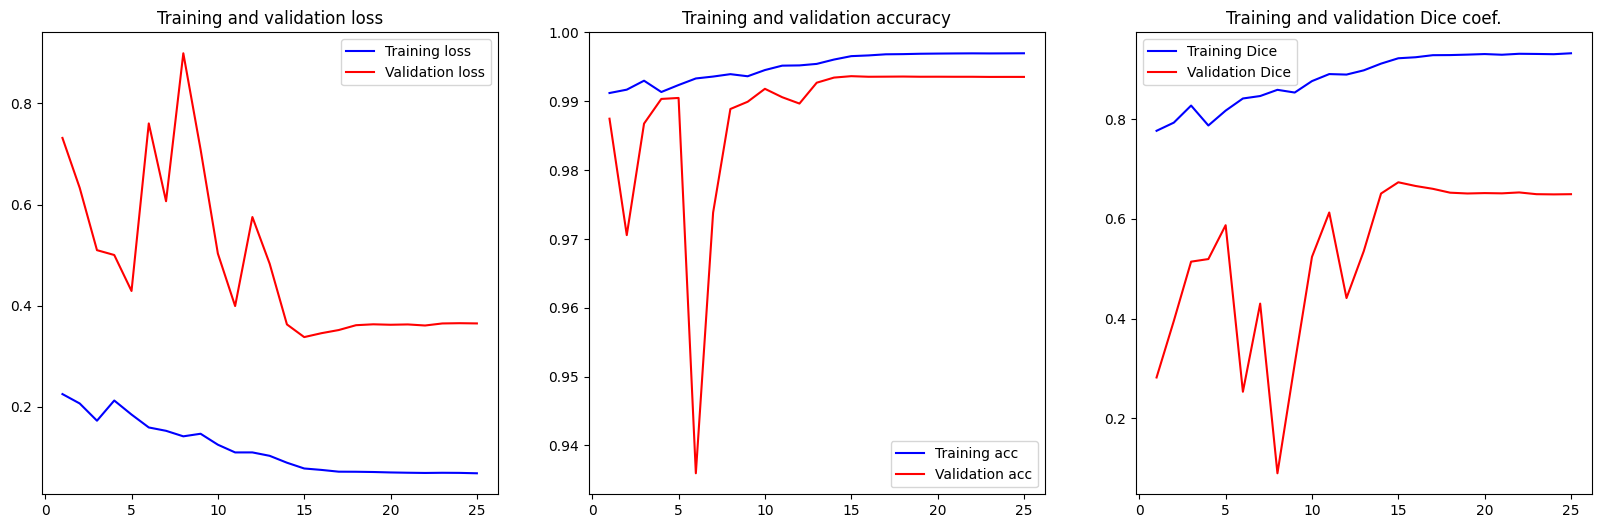

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["acc"]
val_acc = history.history["val_acc"]
dice = history.history["dice_coef"]
val_dice = history.history["val_dice_coef"]
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, acc, "b", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()
plt.subplot(133)
plt.plot(epochs, dice, "b", label="Training Dice")
plt.plot(epochs, val_dice, "r", label="Validation Dice")
plt.title("Training and validation Dice coef.")
plt.legend()

In [ ]:
# 최종 성능
result = model.evaluate(val_input_imgs, val_targets.astype(np.float16))
print('test loss = ', result[0])
print('test Accuracy = ', result[1])
print('test Dice Coef. Score = ', result[2])

4/4 [==============================] - 1s 162ms/step - loss: 0.3698 - acc: 0.9935 - dice_coef: 0.6607
test loss =  0.3698076903820038
test Accuracy =  0.9935463070869446
test Dice Coef. Score =  0.6606671810150146


* Model Prediction

In [ ]:
preds = model.predict(val_input_imgs)
print(len(preds))

4/4 [==============================] - 1s 231ms/step
100


In [ ]:
print(preds[0].shape)

(256, 256, 1)


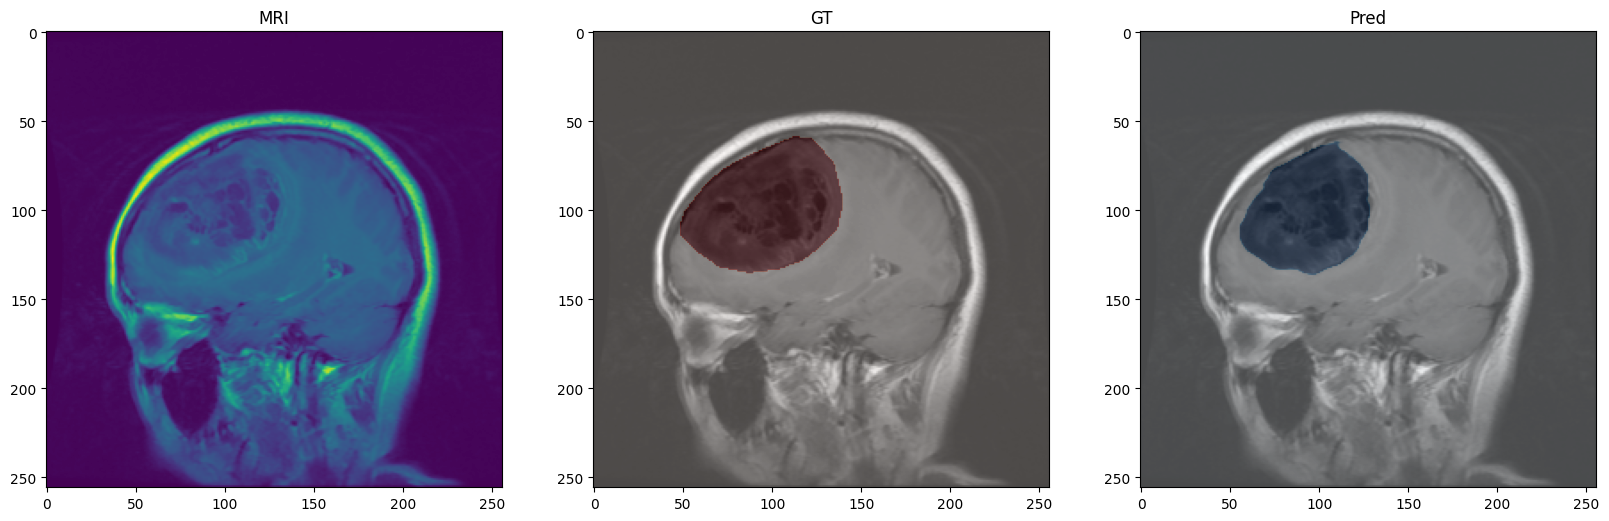

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.title('MRI')
plt.imshow(val_input_imgs[0])
plt.subplot(132)
plt.title('GT')
plt.imshow(val_input_imgs[0], cmap='gray')
plt.imshow(val_targets[0], cmap='Reds', alpha=0.3)
plt.subplot(133)
plt.title('Pred')
plt.imshow(val_input_imgs[0], cmap='gray')
plt.imshow(preds[0], cmap='Blues', alpha=0.3)

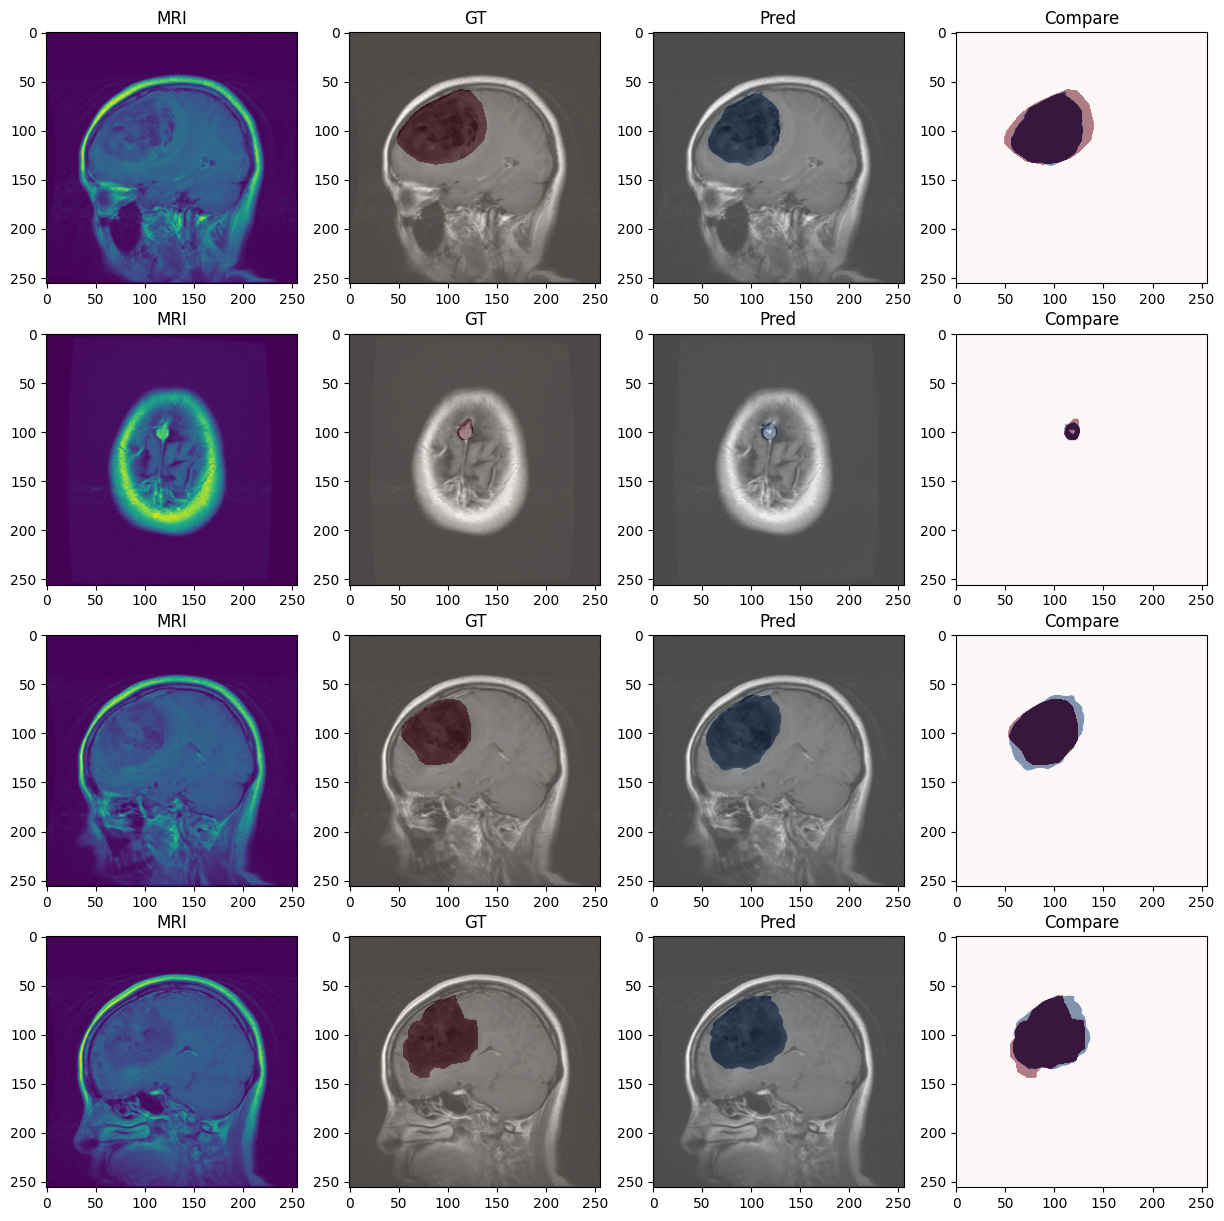

In [ ]:
plt.figure(figsize=(15,15))
for i in range(4):
  plt.subplot(4,4,1+4*i)
  plt.title('MRI')
  plt.imshow(val_input_imgs[i])
  plt.subplot(4,4,2+4*i)
  plt.title('GT')
  plt.imshow(val_input_imgs[i], cmap='gray')
  plt.imshow(val_targets[i], cmap='Reds', alpha=0.3)
  plt.subplot(4,4,3+4*i)
  plt.title('Pred')
  plt.imshow(val_input_imgs[i], cmap='gray')
  plt.imshow(preds[i], cmap='Blues', alpha=0.3)
  plt.subplot(4,4,4+4*i)
  plt.title('Compare')
  plt.imshow(val_targets[i], cmap='Reds', alpha=1)
  plt.imshow(preds[i], cmap='Blues', alpha=0.5)
